In [9]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Lambda, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.layers import add
from keras.layers import Activation
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import classification_report, confusion_matrix
import cv2

import itertools
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pydot
from IPython.display import SVG

In [2]:
def getimages(direct):
    im=[]
    label=[]
    lab=0
    for labels in os.listdir(direct):
        #Label corresponding to folder
        if labels=="buildings":
            lab=0
        if labels=="forest":
            lab=1
        if labels=="glacier":
            lab=2
        if labels=="mountain":
            lab=3
        if labels=="sea":
            lab=4
        if labels=="street":
            lab=5
        for image in os.listdir(direct+r'/'+labels):
            #Read images
            imag=cv2.imread(direct+r'/'+labels+r'/'+image)
            imag=cv2.resize(imag,(150,150))
            
            im.append(imag)
            label.append(lab)
    #Suffle all images
    return shuffle(im, label)

#Obtain both train and test images
im,label=getimages("archive\seg_train\seg_train")      
im1,label1=getimages("archive\seg_test\seg_test") 
img=im+im1
lab=label+label1

#Convert to numpy array
Images=np.array(img)
Labels=np.array(lab)

classes=6

In [4]:
#Split into train, validation and test
x1, xtest, y1,ytest=train_test_split(Images, Labels, random_state=0)
xtrain, xvalidation, ytrain, yvalidation=train_test_split(x1, y1, random_state=0)

#Prepare x
xtrain = xtrain.astype('float32')
xvalidation = xvalidation.astype('float32')
xtest=xtest.astype('float32')
xtrain /= 255
xvalidation /= 255
xtest /= 255


#Prepare y
ytrain0 = keras.utils.to_categorical(ytrain, classes)
yvalidation0 = keras.utils.to_categorical(yvalidation, classes)
ytest0=keras.utils.to_categorical(ytest, classes)

In [5]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [10]:
im_Input = Input(shape=(xtrain.shape[1:]), name="input")
layer = residual_module(im_Input, 64)

In [13]:
layer = Flatten()(layer)
#Inception = Dense(512, activation='relu')(Inception)
layer = Dropout(0.5)(layer)
layer = Dense(classes, activation='softmax')(layer)

In [14]:
baseModel = Model(im_Input, layer)

# compile
baseModel.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [16]:
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model
# make saving directory for checkpoints
baseSaveDir = "./Res/"
if not os.path.isdir(baseSaveDir):
    os.makedirs(baseSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(baseSaveDir, 'Res.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
baseModel = getNewestModel(baseModel, baseSaveDir)

In [17]:
# Number of training/testing examples per batch
batch_size = 50

# Training epochs. 
epochs = 10

# train
history=baseModel.fit(xtrain, ytrain0,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(xvalidation, yvalidation0),
               callbacks=[es_cb,cp_cb])

Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 18.5130 - accuracy: 0.5071
Epoch 00001: val_loss improved from inf to 0.97361, saving model to ./Res\Res.01-0.97.hdf5
192/192 [==============================] - 831s 4s/step - loss: 18.5130 - accuracy: 0.5071 - val_loss: 0.9736 - val_accuracy: 0.6312
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.7303
Epoch 00002: val_loss improved from 0.97361 to 0.91963, saving model to ./Res\Res.02-0.92.hdf5
192/192 [==============================] - 779s 4s/step - loss: 0.7440 - accuracy: 0.7303 - val_loss: 0.9196 - val_accuracy: 0.6662
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8503
Epoch 00003: val_loss did not improve from 0.91963
192/192 [==============================] - 487s 3s/step - loss: 0.4296 - accuracy: 0.8503 - val_loss: 1.0768 - val_accuracy: 0.6703
Epoch 4/10
192/192 [==============================] - ETA: 0s - loss: 0.2105 

In [15]:
baseModel.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 150, 150, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 150, 150, 64) 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 64) 256         input[0][0]                      
_______________________________________________________________________________________

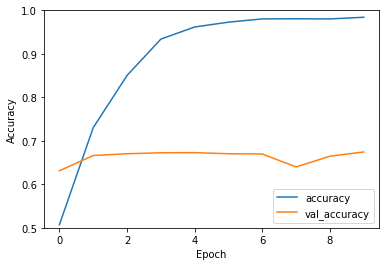

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')